# Clustering and Regression

In this notebook two methods are tried but the obtained results were not promising.
- First a regression based on score of the labels of the MIT dataset
    - Regression methods that were used: SVM regressor, Gradient boosting regressor, Random forest regressor
    - Each time the MSE loss were still significant and the plots show a huge discrepancy between the real and predicted values
- Second a clustering based approach was used, the goal is to group bad interviews together and good interviews together
    - To simplified the task only extreme data was used (score in the 25% upper and 25% lower percentile)
    - Different clustering approached were used (kmeans, mean shift, nearest neighbours, gaussian mixtures and agglomerative clustering).
    - The obtained results are also disppointing.

# Regression

## Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, chi2
import math
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, NearestCentroid

"""
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader"""

'\nimport torch\nimport torch.nn as nn\nimport torchvision\nfrom torchvision import models,transforms,datasets\nimport torch.nn.functional as F\nimport torch.optim as optim\nfrom torch.utils.data.sampler import SubsetRandomSampler\nfrom torch.utils.data import Dataset, DataLoader'

## Data processing

In [2]:
my_dir = "MIT_dataset_APC"

In [3]:
labels_df_raw = pd.read_csv(my_dir+"/Labels/turker_scores_full_interview.csv")

In [4]:
labels_audio = ['Engaged','Excited','SpeakingRate','NoFillers','Friendly','EngagingTone','Calm','NotStressed']


In [5]:
target_label = 'NotStressed'

In [6]:
dataset_df = pd.read_csv(my_dir+"/audio_mit_data_correct")

In [7]:
dataset_df.head()

,Unnamed: 0,Unnamed: 0.1,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,...,Participant,Overall,Engaged,Excited,SpeakingRate,NoFillers,Friendly,EngagingTone,Calm,NotStressed
0,0,0,0.142087,0.015701,3.046386,0.231292,0.223929,1.059157,0.006849,0.224743,...,p4,4.494494,5.494494,4.261343,4.738,3.111445,5.369884,4.392736,5.06519,5.566084
1,1,1,0.087913,0.019020,3.120250,0.188848,0.224495,0.592691,0.006800,0.105566,...,p4,4.494494,5.494494,4.261343,4.738,3.111445,5.369884,4.392736,5.06519,5.566084
2,2,2,0.103410,0.012062,3.087032,0.190073,0.204567,0.825101,0.009216,0.160579,...,p4,4.494494,5.494494,4.261343,4.738,3.111445,5.369884,4.392736,5.06519,5.566084
3,3,3,0.091148,0.018467,3.034920,0.188826,0.221233,0.657817,0.008772,0.129651,...,p4,4.494494,5.494494,4.261343,4.738,3.111445,5.369884,4.392736,5.06519,5.566084
4,4,4,0.066190,0.028290,3.151099,0.171390,0.215667,0.499517,0.007204,0.089610,...,p4,4.494494,5.494494,4.261343,4.738,3.111445,5.369884,4.392736,5.06519,5.566084


In [8]:
meaningful_cols = ['zcr_mean', 'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean', 'spectral_spread_mean', 
                   'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean', 
                   'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
                   'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean',
                   'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 
                   'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean',
                   'chroma_std_mean', 'delta zcr_mean', 'delta energy_mean', 'delta energy_entropy_mean', 
                   'delta spectral_centroid_mean', 'delta spectral_spread_mean', 'delta spectral_entropy_mean',
                   'delta spectral_flux_mean', 'delta spectral_rolloff_mean', 'delta mfcc_1_mean', 'delta mfcc_2_mean',
                   'delta mfcc_3_mean', 'delta mfcc_4_mean', 'delta mfcc_5_mean', 'delta mfcc_6_mean',
                   'delta mfcc_7_mean', 'delta mfcc_8_mean', 'delta mfcc_9_mean', 'delta mfcc_10_mean', 
                   'delta mfcc_11_mean', 'delta mfcc_12_mean', 'delta mfcc_13_mean', 'delta chroma_1_mean',
                   'delta chroma_2_mean', 'delta chroma_3_mean', 'delta chroma_4_mean', 'delta chroma_5_mean', 
                   'delta chroma_6_mean', 'delta chroma_7_mean', 'delta chroma_8_mean', 'delta chroma_9_mean',
                   'delta chroma_10_mean', 'delta chroma_11_mean', 'delta chroma_12_mean', 'delta chroma_std_mean',
                   'zcr_std', 'energy_std', 'energy_entropy_std', 'spectral_centroid_std', 'spectral_spread_std', 
                   'spectral_entropy_std', 'spectral_flux_std', 'spectral_rolloff_std', 'mfcc_1_std', 'mfcc_2_std', 
                   'mfcc_3_std', 'mfcc_4_std', 'mfcc_5_std', 'mfcc_6_std', 'mfcc_7_std', 'mfcc_8_std', 'mfcc_9_std', 
                   'mfcc_10_std', 'mfcc_11_std', 'mfcc_12_std', 'mfcc_13_std', 'chroma_1_std', 'chroma_2_std', 
                   'chroma_3_std', 'chroma_4_std', 'chroma_5_std', 'chroma_6_std', 'chroma_7_std', 'chroma_8_std',
                   'chroma_9_std', 'chroma_10_std', 'chroma_11_std', 'chroma_12_std', 'chroma_std_std',
                   'delta zcr_std', 'delta energy_std', 'delta energy_entropy_std', 'delta spectral_centroid_std',
                   'delta spectral_spread_std', 'delta spectral_entropy_std', 'delta spectral_flux_std',
                   'delta spectral_rolloff_std', 'delta mfcc_1_std', 'delta mfcc_2_std', 'delta mfcc_3_std',
                   'delta mfcc_4_std', 'delta mfcc_5_std', 'delta mfcc_6_std', 'delta mfcc_7_std', 
                   'delta mfcc_8_std', 'delta mfcc_9_std', 'delta mfcc_10_std', 'delta mfcc_11_std',
                   'delta mfcc_12_std', 'delta mfcc_13_std', 'delta chroma_1_std', 'delta chroma_2_std', 
                   'delta chroma_3_std', 'delta chroma_4_std', 'delta chroma_5_std', 'delta chroma_6_std', 
                   'delta chroma_7_std', 'delta chroma_8_std', 'delta chroma_9_std', 'delta chroma_10_std', 
                   'delta chroma_11_std', 'delta chroma_12_std', 'delta chroma_std_std', 'meanF0Hz', 'stdevF0Hz', 
                   'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                   'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer',
                   target_label]

In [9]:
list_cols = dataset_df.columns
print(list(list_cols[2:-10]))

['zcr_mean', 'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean', 'spectral_spread_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean', 'chroma_std_mean', 'delta zcr_mean', 'delta energy_mean', 'delta energy_entropy_mean', 'delta spectral_centroid_mean', 'delta spectral_spread_mean', 'delta spectral_entropy_mean', 'delta spectral_flux_mean', 'delta spectral_rolloff_mean', 'delta mfcc_1_mean', 'delta mfcc_2_mean', 'delta mfcc_3_mean', 'delta mfcc_4_mean', 'delta mfcc_5_mean', 'delta mfcc_6_mean', 'delta mfcc_7_mean', 'delta mfcc_8_mean', 'delta mfcc_9_

In [10]:
print(len(list_cols))

162


In [11]:
list_cols = list(list_cols[2:-10])
list_cols.append(target_label)
selected_columns = list_cols
#print(selected_columns)

In [12]:
x_df = dataset_df[meaningful_cols]

In [13]:
x_df.shape

(22344, 151)

In [14]:
print(x_df.columns)

Index(['zcr_mean', 'energy_mean', 'energy_entropy_mean',
       'spectral_centroid_mean', 'spectral_spread_mean',
       'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean',
       'mfcc_1_mean', 'mfcc_2_mean',
       ...
       'rapJitter', 'ppq5Jitter', 'ddpJitter', 'localShimmer',
       'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer',
       'ddaShimmer', 'NotStressed'],
      dtype='object', length=151)


In [15]:
#x_df.describe()

In [16]:
columns_with_nan_values = []
for clmn in x_df.columns:
  num = len(x_df[clmn].values[x_df[clmn].isnull()])
  if (num !=0):
    columns_with_nan_values.append(clmn)
print(len(columns_with_nan_values))

14


In [17]:
x_df.dropna(subset = columns_with_nan_values, inplace=True)

/Users/ahmedewva/opt/anaconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
x_df.head(600)

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,...,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,NotStressed
1,0.087913,0.019020,3.120250,0.188848,0.224495,0.592691,0.006800,0.105566,-24.769166,2.399408,...,0.010623,0.011196,0.031870,0.175974,1.552526,0.077874,0.115512,0.197128,0.233621,5.566084
2,0.103410,0.012062,3.087032,0.190073,0.204567,0.825101,0.009216,0.160579,-25.428056,2.182121,...,0.006705,0.007249,0.020115,0.181709,1.523556,0.084271,0.129299,0.190310,0.252814,5.566084
3,0.091148,0.018467,3.034920,0.188826,0.221233,0.657817,0.008772,0.129651,-24.688089,2.340357,...,0.020790,0.021229,0.062370,0.208734,1.789219,0.108183,0.138046,0.110888,0.324549,5.566084
4,0.066190,0.028290,3.151099,0.171390,0.215667,0.499517,0.007204,0.089610,-24.409609,2.427913,...,0.009059,0.008628,0.027178,0.165879,1.606036,0.083539,0.090342,0.117668,0.250618,5.566084
6,0.111811,0.029945,3.054400,0.207635,0.216334,0.784833,0.008146,0.178350,-23.895809,2.290027,...,0.013007,0.012970,0.039022,0.189562,1.689502,0.099301,0.108843,0.141086,0.297903,5.566084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,0.075348,0.022374,3.151738,0.184740,0.219224,0.510915,0.009059,0.110519,-24.758165,2.184079,...,0.011791,0.011800,0.035372,0.173493,1.600296,0.080761,0.107990,0.203845,0.242282,5.916373
705,0.082274,0.034221,3.090658,0.185043,0.215408,0.577165,0.010313,0.115434,-24.734029,2.161660,...,0.008975,0.010615,0.026924,0.168881,1.561658,0.076960,0.109381,0.171172,0.230881,5.916373
706,0.180158,0.037546,3.142509,0.274110,0.242520,0.833836,0.008600,0.261494,-24.212035,2.374659,...,0.008087,0.008818,0.024261,0.170630,1.446250,0.085757,0.106679,0.151929,0.257272,5.916373
707,0.124962,0.020255,3.149749,0.231993,0.216641,0.955861,0.023883,0.245047,-37.364562,1.606849,...,0.004074,0.005264,0.012223,0.125844,1.162346,0.057132,0.075692,0.116810,0.171397,5.916373


In [19]:
y_df = x_df[target_label]
x_df.drop(columns=target_label, inplace=True)

/Users/ahmedewva/opt/anaconda3/envs/xai/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
X_train_before_sc, X_test_before_sc, y_train, y_test = train_test_split(x_df.values, y_df.values, test_size=0.15, random_state=42)
X_train_before_sc, X_validation_before_sc, y_train, y_validation = train_test_split(X_train_before_sc, y_train, test_size=0.25, random_state=42)

scaler = StandardScaler()
#X_train_before_sc = X_train_before_sc.astype(float)
scaler.fit(X_train_before_sc)
X_train = scaler.transform(X_train_before_sc)
X_validation = scaler.transform(X_validation_before_sc)
X_test = scaler.transform(X_test_before_sc)

## Support vector machine regressor

In [21]:
reg_svr = SVR(kernel='rbf')
reg_svr.fit(X_train,y_train)

SVR()

In [22]:
reg_svr.score(X_train, y_train, sample_weight=None)

0.49457618098257794

In [23]:
reg_svr.score(X_test, y_test)

0.12667902827922062

In [25]:
y_pred_svr = reg_svr.predict(X_train)

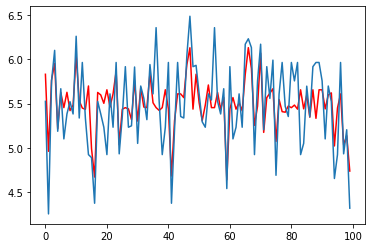

In [26]:
n = 100
pred = np.zeros(n)
real = np.zeros(n)
diff = np.zeros(n)

for i in range (n):
  pred[i] = y_pred_svr[i]
  real[i] = y_train[i]
  diff[i] = np.abs(real[i]-pred[i])


plt.plot(pred,'r')
plt.plot(real)
plt.show()

## Gradient boosting regressor

In [27]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

In [28]:
reg_gb = ensemble.GradientBoostingRegressor(**params)
reg_gb.fit(X_train, y_train)



GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [29]:
mse = mean_squared_error(y_test, reg_gb.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.2222


In [30]:
gb_score_train = reg_gb.score(X_train, y_train)
gb_score_test = reg_gb.score(X_train, y_train)
y_pred_gb = reg_gb.predict(X_train)

In [31]:
print(gb_score_train)
print(gb_score_test)

0.18911165215850378
0.18911165215850378


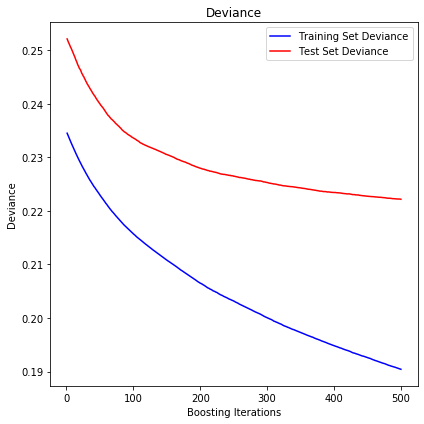

In [32]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg_gb.staged_predict(X_test)):
    test_score[i] = reg_gb.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg_gb.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

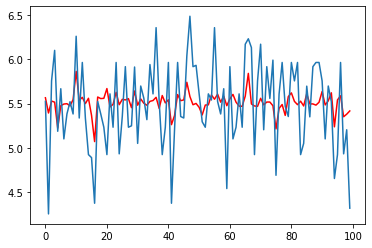

In [33]:
n = 100
pred = np.zeros(n)
real = np.zeros(n)
diff = np.zeros(n)

for i in range (n):
  pred[i] = y_pred_gb[i]
  real[i] = y_train[i]
  diff[i] = np.abs(real[i]-pred[i])


plt.plot(pred,'r')
plt.plot(real)
plt.show()

## Random Forest regressor

In [34]:
reg_rf = RandomForestRegressor(max_depth=2, random_state=0)

In [35]:
reg_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [36]:
rf_score_train = reg_rf.score(X_train, y_train)
rf_score_test = reg_rf.score(X_train, y_train)

In [39]:
mse = mean_squared_error(y_test, reg_rf.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))



The mean squared error (MSE) on test set: 0.3438


In [40]:
y_pred_rf = reg_rf.predict(X_test)

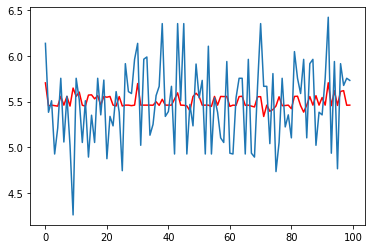

In [41]:
n = 100
pred = np.zeros(n)
real = np.zeros(n)
diff = np.zeros(n)

for i in range (n):
  pred[i] = y_pred_rf[i]
  real[i] = y_test[i]
  diff[i] = np.abs(real[i]-pred[i])


plt.plot(pred,'r')
plt.plot(real)
plt.show()

# Clustering

In [96]:
X_values = x_df.values
Y_values = y_df.values

In [97]:
def getting_indexes (index_quality):
    index_arr = index_quality.values
    l=[]
    n = len(index_arr)
    for i in range(n):
        if index_arr[i] == True :
            l.append(i)
    return np.array(l)

In [98]:
index_good_interviews = y_df.rank(pct=True) > 0.75
index_bad_interviews = y_df.rank(pct=True) <= 0.25

In [99]:
len(getting_indexes(index_bad_interviews))/len(Y_values)

0.25146169854325634

In [100]:
a = len(y_df[index_good_interviews].values)
b = len(getting_indexes(index_bad_interviews))


values_clustering = np.concatenate((y_df[index_good_interviews].values,y_df[index_bad_interviews].values),axis=0)
indexes = np.concatenate((getting_indexes(index_good_interviews),getting_indexes(index_bad_interviews)))
#print(indexes)
#print(len(indexes)/len(Y_values))

tmp = max(y_df[index_bad_interviews].values)

real_labels = np.concatenate((np.ones(a),np.zeros(b)),axis=0)



selected_x_values_for_clustering = np.concatenate((x_df[index_good_interviews].values,x_df[index_bad_interviews].values),axis=0)
#print(len(selected_x_values_for_clustering)/len(Y_values))

In [101]:
kmeans = KMeans(n_clusters=2, random_state=3).fit(selected_x_values_for_clustering)
print(1)
ms = MeanShift(bandwidth=2).fit(selected_x_values_for_clustering)

1


In [26]:
gm = GaussianMixture(n_components=2, random_state=0).fit(selected_x_values_for_clustering)

In [ ]:
sp = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=3).fit(selected_x_values_for_clustering)
print(2)

In [28]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(selected_x_values_for_clustering)
print(3)


3


In [ ]:
agg = AgglomerativeClustering().fit(selected_x_values_for_clustering)
print(5)

In [102]:
y_pred_kmeans = kmeans.labels_
#y_pred_ms = ms.labels_
#y_pred_gm = gm.predict(selected_x_values_for_clustering)
#y_pred_nbrs = nbrs.predict(selected_x_values_for_clustering)
#y_pred_agg = agg.labels_

#y_pred = ms_clustering.predict(selected_x_values_for_clustering)

In [103]:
print(len(y_pred))

3028


In [104]:
acc = sum(y_pred_kmeans==real_labels)

In [105]:
R_kmeans = np.corrcoef(y_pred_kmeans, real_labels)
#R_ms = np.corrcoef(y_pred_ms, real_labels)
#R_gm = np.corrcoef(y_pred_gm, real_labels)
#R_nbrs = np.corrcoef(y_pred_nbrs, real_labels)
#R_agg = np.corrcoef(y_pred_agg, real_labels)


print( "correlation coefficient with kmeans:  ", R_kmeans)
#print( "correlation coefficient with mean shift:  ", R_ms)
#print( "correlation coefficient with gaussian mixture:  ", R_gm)
#print( "correlation coefficient with nearest neighbors:  ", R_nbrs)
#print( "correlation coefficient with agglomerative clustering:  ", R_agg)

correlation coefficient with kmeans:   [[1.        0.1463533]
 [0.1463533 1.       ]]


In [106]:
print(acc/len(y_pred_kmeans))
R1 = np.corrcoef(y_pred_kmeans, real_labels)
print(R1)


0.572239624119029
[[1.        0.1463533]
 [0.1463533 1.       ]]


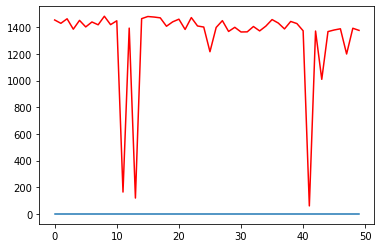

In [107]:
n = 10000
plt.plot(y_pred_ms[n:n+50], 'r')
plt.plot(real_labels[n:n+50])
plt.show()

In [48]:
def good_bad_transform(y):
    m = np.mean(y)
    n = len(y)
    l = np.zeros(n)
    for i in range(n):
        if (y[i]>=m):
            l[i] = 1
    return l

In [49]:
y_good_bad = good_bad_transform(Y_values)

In [62]:
Y_total_pred = ms.predict(selected_x_values_for_clustering)

In [63]:
Y_total_pred

array([ 178,  251,  212, ..., 2927, 3002, 2741])

In [61]:
X_values[0].reshape(1,-1)

array([[ 1.13325008e-01,  1.76869344e-02,  3.10402328e+00,
         2.22891866e-01,  2.32063115e-01,  7.95691413e-01,
         8.08237235e-03,  1.86970659e-01, -2.54608040e+01,
         2.36720718e+00,  3.89088380e-02, -3.02567712e-01,
        -5.61525413e-01,  2.28588798e-02,  1.67696034e-02,
        -8.49622467e-02, -3.78918367e-01,  2.21778789e-04,
        -3.75415222e-01, -6.61561470e-02, -1.91652245e-01,
         2.26857859e-02,  5.36150243e-03,  6.61359063e-02,
         2.27693944e-02,  1.64876604e-02,  1.60973374e-02,
         2.06054344e-02,  6.79075530e-03,  1.02732605e-02,
         7.46009619e-03,  8.21032783e-03,  2.86442001e-03,
         2.54806625e-02,  4.91976991e-04,  3.70127231e-04,
        -1.58051260e-03,  4.53018976e-04,  7.83441931e-05,
         6.70675535e-03,  1.92762714e-04,  9.83061101e-04,
         7.33591251e-02, -1.68199089e-02, -4.32266644e-02,
        -1.09503551e-03, -9.58220947e-03, -8.85099615e-05,
         1.18509427e-02,  3.18738710e-03,  8.46084160e-0

In [64]:
print(y_pred_ms)

[ 178  251  212 ... 2927 3002 2741]
